In [ ]:
!pip install openpyxl
!pip install spacy
!python -m spacy download en_core_web_sm
pip install wordcloud


In [ ]:
import requests
import zipfile
import io
import os
import re
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

In [ ]:
######################################## General Functions #########################3

# 1- Function for showing the dataframe characteristics

def data_details(df, n=5):
     print("\n")
     print("Shape:")
     print(df.shape)
     print("\n")
    
     print("\n The Head")
     display(df.head(n))  
     print("\n")

     print("\n Info:")
     print(df.info(memory_usage="deep"))
     print("\n") 

     print("\n The Null Values:")
     print(df.isnull().sum())
     print("\n") 

     print("\nSummary statistics (categorical):")  # As our needed features are categorical 
     categorical_cols = df.select_dtypes(include=[object]).columns
     if len(categorical_cols) > 0:
         display(df.describe(include=[object]))
     else:
         print("No categorical columns found.")
         print("\n")    

# 2- Function for cleaning the DataFrame (Normalization) 

def clean_text(text, mode="input" ,lowercase=True):
                                 # input (features [ product_name , brand , category , subcatogry] or the target [description])
    if pd.isna(text):
        return ""
   
    if lowercase:
        text = text.lower()
     
    text = re.sub(r"<.*?>", " ", text) # Remove HTML tags
    text = re.sub(r"(https?://\S+|www\.\S+|ftp://\S+)", " ", text) # Remove URLs

    if mode == "description":
        text = re.sub(r"[^a-z0-9\s&-]", " ", text) # For descriptions: keep only letters, numbers, spaces, &, -
    
    else:  # mode == "input features"
        
        text = re.sub(r"&", " & ", text) # Add spaces around &     
        text = re.sub(r"([a-z])([A-Z])", r"\1 \2", text)  # Split camelCase or PascalCase 
        text = re.sub(r"(\||/|>)", " > ", text) # Normalize separators (|, /, >) to " > " as some product names contains | symbole 

        if lowercase: #
           text = re.sub(r"[^a-z0-9\s&'\->]", " ", text)  # Keep allowed chars: a-z, 0-9, spaces, &, -, >,'(lowercase for category & sub_catogry)
        else:
           text = re.sub(r"[^a-zA-Z0-9\s&'\->]", " ", text) # (uppercase for product_name & brand)

    text = re.sub(r"\s+", " ", text).strip()  # Normalize multiple spaces to single space
    text = re.sub(r"( > )+", " > ", text) # Normalize multiple > in a row  
    text = text.strip(" >") # Remove leading/trailing >

    return text
### apply cleaning functions on columns

"""
    Clean product, brand, category, sub_category, and description.
    Restore original casing of product/brand inside description.
    Remove duplicates and empty descriptions.
"""
def preprocess_dataset_clean_only(df):
    clean_df = pd.DataFrame()

    # Clean product_name and brand (keep original casing)
    clean_df["clean_product_name"] = df["product_name"].apply(
        lambda x: clean_text(x, mode="input", lowercase=False)
    )
    clean_df["clean_brand"] = df["brand"].apply(
        lambda x: clean_text(x, mode="input", lowercase=False)
    )

    # Clean category and sub_category (convert to lowercase)
    clean_df["clean_category"] = df["category"].apply(
        lambda x: clean_text(x, mode="input", lowercase=True)
    )
    clean_df["clean_sub_category"] = df["sub_category"].apply(
        lambda x: clean_text(x, mode="input", lowercase=True)
    )

    # Clean description (convert to lowercase)
    clean_df["clean_description"] = df["description"].apply(
        lambda x: clean_text(x, mode="description", lowercase=True)
    )

    # Restore original casing of product name and brand inside the description
    def restore_casing(row):
        desc = row["clean_description"]
        for token in row["clean_product_name"].split():
            pattern = r"\b" + re.escape(token.lower()) + r"\b"
            desc = re.sub(pattern, token, desc)
        for token in row["clean_brand"].split():
            pattern = r"\b" + re.escape(token.lower()) + r"\b"
            desc = re.sub(pattern, token, desc)
        return desc

    clean_df["clean_description"] = clean_df.apply(restore_casing, axis=1)

    # Drop duplicates and empty rows
    clean_df = clean_df.drop_duplicates(subset=["clean_description"])
    clean_df = clean_df[clean_df["clean_description"] != ""].reset_index(drop=True)

    return clean_df

#3- function for Tokenization / Lemmatization 

def tokenize_lemmatize(texts, product_names, brands, nlp):
    """
    Tokenize and lemmatize a list of texts using spaCy,
    while preserving original casing for product/brand tokens.
    Returns: list of token lists.
    """
    preserve_sets = [
        set(prod.split()) | set(br.split())
        for prod, br in zip(product_names, brands)
    ]

    result_tokens = []
    for doc, preserve in zip(nlp.pipe(texts, batch_size=64), preserve_sets):
        tokens = []
        for token in doc:
            if token.text in preserve:
                tokens.append(token.text)              # keep product/brand tokens
            elif not token.is_stop and token.is_alpha:
                tokens.append(token.lemma_)            # lemmatize normal words
        result_tokens.append(tokens)

    return result_tokens

# 4) Main call to run both cleaning + tokenization   (ready for model from scratch)

def process_for_model(df, nlp):
    """
    Clean the dataset and add a tokenized/lemmatized version of the description.
    """
    clean_df = preprocess_dataset_clean_only(df)
    clean_df["description_tokens"] = tokenize_lemmatize(
        clean_df["clean_description"].tolist(),
        clean_df["clean_product_name"].tolist(),
        clean_df["clean_brand"].tolist(),
        nlp
    )
    # Drop clean_description if you only need tokens
    # clean_df = clean_df.drop(columns=["clean_description"])
    return clean_df


In [4]:
### Download Data From Github

zip_url = 'https://raw.githubusercontent.com/Eng-Shady-Hub/Generative_AI_Project_Round3/refs/heads/main/All_Datasets.zip'
response = requests.get(zip_url)
response.raise_for_status()

In [ ]:
## Reading the CSV files from the Zip and save them individually

dataframes = {}

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    csv_files = [f for f in z.namelist() if f.endswith(".csv")]

    if not csv_files:
        print("No CSV_Files")
    else:
        for i, file_name in enumerate(csv_files, start=1):
            with z.open(file_name) as f:
                key = f"df{i}"
                dataframes[key] = pd.read_csv(f)
                print(f'DataFrame "{key}" created from file {file_name}')

In [ ]:
# DataFrame 1

basket_data = dataframes["df1"]
# data_details(basket_data)

# target = [description]
# features = [product_name ,brand ,category, sub_category]
basket_data = basket_data[["product","brand","category" , "sub_category","description"]]
basket_data= basket_data.rename(columns={"product": "product_name"})
print(basket_data.columns)

# there are null values in product_name , brand & description columns
basket_data=basket_data.dropna(subset=["description","product_name","brand"])
data_details(basket_data)


In [ ]:
# DataFrame 2

adidas_data = dataframes["df2"]
# data_details(adidas_data)

# Unify columns names
adidas_data = adidas_data[["Product Name", "Brand", "Description"]].rename(columns={"Product Name": "product_name", "Brand": "brand" , "Description":"description"})
adidas_data.info()

# there are null values(only 3) in description column
adidas_data=adidas_data.dropna(subset=["description"])
adidas_data =adidas_data[adidas_data['description'] != 'No description']
adidas_data.isnull().sum()

# Dataset has agood description to our model but not have category & sub_category columns
# So we map category & sub_category columns with respect to the product_name column
category_map = {
    # cayrgory = footwear 
  "shoe": ("footwear", "shoes"),"sneaker": ("footwear", "shoes"),"running": ("footwear", "running shoes"),"trainer": ("footwear", "trainers"),"cleat": ("footwear", "cleats"),
    "slipper": ("footwear", "slippers"),"flip flop": ("footwear", "flip flops"),"jordan": ("footwear", "basketball shoes"),"retro": ("footwear", "shoes"),
    "phantom": ("footwear", "cleats"),"venom": ("footwear", "cleats"),"mercurial": ("footwear", "soccer shoes"),"superfly": ("footwear", "soccer shoes"),
    "tf": ("footwear", "turf soccer shoes"),"air max": ("footwear", "sneakers"),"p-6000": ("footwear", "running shoes"),"sandal": ("footwear", "sandals"),
    "slide": ("footwear", "slides"),"adilette": ("footwear", "slides"),"flipflop": ("footwear", "flip flops"),"sb": ("footwear", "skate shoes"),"skate": ("footwear", "skate shoes"),
    "chron": ("footwear", "skate shoes"),"kd": ("footwear", "basketball shoes"),"kyrie": ("footwear", "basketball shoes"),"iconclash": ("footwear", "running shoes"),
    "daybreak": ("footwear", "sneakers"),"blazer": ("footwear", "sneakers"),"prelove": ("footwear", "sneakers"),"pegasus": ("footwear", "running shoes"),
    "vaporfly": ("footwear", "running shoes"),"zoomx": ("footwear", "running shoes"),"slipon": ("footwear", "slip-ons"),"airforce": ("footwear", "sneakers"),
    "airmax": ("footwear", "sneakers"),"metcon": ("footwear", "training shoes"),"court": ("footwear", "tennis shoes"),"pg": ("footwear", "basketball shoes"),
    "m2k": ("footwear", "sneakers"),"winflo": ("footwear", "running shoes"),"vomero": ("footwear", "running shoes"),"vapormax": ("footwear", "lifestyle sneakers"),
    "flip-flop": ("footwear", "flip flops"),"flip-flops": ("footwear", "flip flops"),"slip-on": ("footwear", "slip-ons"), "slip-ons": ("footwear", "slip-ons"),
    "odyssey react": ("footwear", "running shoes"),"legend react": ("footwear", "running shoes"),"pre-love": ("footwear", "sneakers"),"air force": ("footwear", "sneakers"),
    "drop-type": ("footwear", "running shoes"),"zoom rival fly": ("footwear", "running shoes"),"mx-720-818": ("footwear", "running shoes"),"tanjun": ("footwear", "running shoes"),
    "superstar": ("footwear", "sneakers"),"slip on": ("footwear", "slip-ons"),"lebron soldier": ("footwear", "basketball shoes"),"react element": ("footwear", "running shoes"),
    "free rn": ("footwear", "running shoes"),"zoom fly": ("footwear", "running shoes"),"zoom rise": ("footwear", "running shoes"),"tiempo legend": ("footwear", "soccer shoes"),
    "flex rn": ("footwear", "running shoes"),"air zoom structure": ("footwear", "running shoes"),"sfb gen 2": ("footwear", "boots"),"air huarache": ("footwear", "sneakers"),
    "wildhorse": ("footwear", "running shoes"),"benassi": ("footwear", "slides"),"terra kiger": ("footwear", "running shoes"),"classic cortez": ("footwear", "sneakers"),
    "renew run": ("footwear", "running shoes"),"free tr": ("footwear", "training shoes"),"lebron": ("footwear", "basketball shoes"),"mowabb": ("footwear", "sneakers"),
    "revolution": ("footwear", "running shoes"),"precision": ("footwear", "basketball shoes"),"shox": ("footwear", "running shoes"),"potential": ("footwear", "basketball shoes"),
    "epic react": ("footwear", "running shoes"), "react city": ("footwear", "running shoes"),"kawa": ("footwear", "slides"),"joyride run": ("footwear", "running shoes"),
    "joyride optik": ("footwear", "running shoes"),"flex contact": ("footwear", "running shoes"),"football": ("footwear", "Football Shoes"),"predator": ("footwear", "Football Shoes"),
    "vandalised": ("footwear", "Casual Shoes"),"canyon": ("footwear", "Casual Shoes"),"react": ("footwear", "Running Shoes"),"acg": ("footwear", "Outdoor Shoes"),
    "flex": ("footwear", "Training Shoes"),"signal": ("footwear", "Running Shoes"),"joyride": ("footwear", "Running Shoes"),"cortez": ("footwear", "Casual Shoes"),
    "hawkins": ("footwear", "Casual Shoes"),"nemeziz": ("footwear", "Football Shoes"),"indoor": ("footwear", "Indoor Shoes"),"outdoor": ("footwear", "Outdoor Shoes"),
    "trail": ("footwear", "Outdoor Shoes"),"superrep": ("footwear", "Training Shoes"),"zoom": ("footwear", "Running Shoes"),"tr": ("footwear", "Training Shoes"),
    "renew": ("footwear", "Running Shoes"),"ghost": ("footwear", "Running Shoes"),"racer": ("footwear", "Running Shoes"),"alphadunk": ("footwear", "Basketball Shoes"),
    "monarch": ("footwear", "Walking Shoes"),"af-1": ("footwear", "Casual Shoes"),"bella": ("footwear", "Casual Shoes"), "huarache": ("footwear", "Lifestyle Shoes"),
    "solarsoft": ("footwear", "Training Shoes"),"exp-x14": ("footwear", "Running Shoes"),"fly.by": ("footwear", "Basketball Shoes"),"xarr": ("footwear", "Training Shoes"),
    "skarn": ("footwear", "Casual Shoes"),"tailwind": ("footwear", "Running Shoes"), "air dsvm": ("footwear", "Running Shoes"),
    # category = accessories
    "sock": ("accessories", "socks"), "cap": ("accessories", "cap"),"hat": ("accessories", "cap"),"bag": ("accessories", "bag"),"backpack": ("accessories", "bag"),
    "watch": ("accessories", "watch")
    }
    
def categorize_product(name):
    name = str(name).lower()
    for keyword, (cat, subcat) in category_map.items():
        if keyword in name:
            return cat, subcat
    return "Other", "Other"  # fallback if no keyword found

adidas_data[["category", "sub_category"]] = adidas_data["product_name"].apply(lambda x: pd.Series(categorize_product(x)))

# arranging the columns to be the same in all datasets
adidas_data = adidas_data[["product_name", "brand","category", "sub_category", "description"]]
print(adidas_data.columns)
data_details(adidas_data , n=20)


In [ ]:
# DataFrame 3

amazon_data =dataframes["df3"] 
# data_details(amazon_data)

# there is no null values in the prefered dataset features
#  Amazon dataset don't contain brand , we note the first name in the product_name is the brand
# So creating a function to map the brand column with respect to product_name column
def map_brand(name):
    return name.split()[0]

# Apply function
amazon_data['brand'] =amazon_data['product_name'].apply(map_brand)

#  Amazon dataset don't contain sub_category , we note the values in category colums are diveded by | 
# So creating it by map sub_category column with respect to category column by extracting the most specific level(last part)
amazon_data['sub_category'] = amazon_data['category'].apply(lambda x: x.split('|')[-1])
# amazon_data.head()

# arranging the columns to be the same in all datasets
amazon_data = amazon_data[["product_name", "brand","category", "sub_category", "about_product"]]
amazon_data= amazon_data.rename(columns={"about_product": "description"})
print(amazon_data.columns)
data_details(amazon_data)

In [ ]:
# DataFrame 4
 
flipkart_data = dataframes["df4"]
# data_details(flipkart_data)

# there are nulls in description an brand columns
# clearing "discription" rows with missed values
flipkart_data=flipkart_data.dropna(subset=["description"])
flipkart_data =flipkart_data[flipkart_data['description'] != 'No description']
flipkart_data.isnull().sum()

# display the most common brand to fill the missing value 
most_common = flipkart_data['brand'].mode()[0]
# print(most_common)

# filling the missed value of brand By common brand in our dataset "REEB"
flipkart_data['brand'] = flipkart_data['brand'].fillna('REEB')

# arranging the columns to be the same in all datasets
flipkart_data = flipkart_data[["title", "brand","category", "sub_category", "description"]]
flipkart_data= flipkart_data.rename(columns={"title": "product_name"})
print(flipkart_data.columns)
flipkart_data.isnull().sum()
data_details(flipkart_data)


In [ ]:
# DataFrame 5

adidas2_data =dataframes["df5"] 
# data_details(adidas2_data)

# adidas2 dataset not have null values
#  Noting the breadcrumbs colums contains sub_category
adidas2_data = adidas2_data[["name", "brand","category", "breadcrumbs", "description"]]
adidas2_data= adidas2_data.rename(columns={"name": "product_name" , "breadcrumbs":"sub_category"})
print(adidas2_data.columns)
data_details(adidas2_data)

In [11]:
# DataFrame 6

elec_data = dataframes["df6"]
# data_details(elec_data)

# The elec_data dataSet is clear 
elec_data= elec_data.rename(columns={"Product_name": "product_name"})
print(elec_data.columns)


Index(['product_name', 'brand', 'category', 'sub_category', 'description'], dtype='object')


In [ ]:
# Combining all datasets 
Final_data = pd.concat([basket_data, adidas_data, amazon_data ,adidas2_data , flipkart_data , elec_data], ignore_index=True)
data_details(Final_data)

In [ ]:
## Saving Final DataSet
save_path = os.path.expanduser("~/Documents/Final_data.csv")
Final_data.to_csv(save_path, index=False, encoding="utf-8")
print("Dataset Saved to : ", save_path)

In [ ]:
# Applying on Data, Just clean (ready for Fine-Tune Pre-trained Model)

clean_Final_data = preprocess_dataset_clean_only(Final_data)
data_details(clean_Final_data)
#Saving to CSV file


In [ ]:
#Saving to CSV file
save_path = os.path.expanduser("~/Documents/clean_Final_data.csv")
clean_Final_data.to_csv(save_path, index=False, encoding="utf-8")
print("Dataset Saved to : ", save_path)

In [ ]:
#  Applying on Data, Clean + tokens (ready for model from scratch)

clean_Final_data_model = process_for_model(Final_data, nlp)
clean_Final_data_model.head(10)



In [17]:
#Saving to CSV file
save_path = os.path.expanduser("~/Documents/clean_Final_data_model.csv")
clean_Final_data_model.to_csv(save_path, index=False, encoding="utf-8")
print("Dataset Saved to : ", save_path)

Dataset Saved to :  C:\Users\Shadwa/Documents/clean_Final_data_model.csv


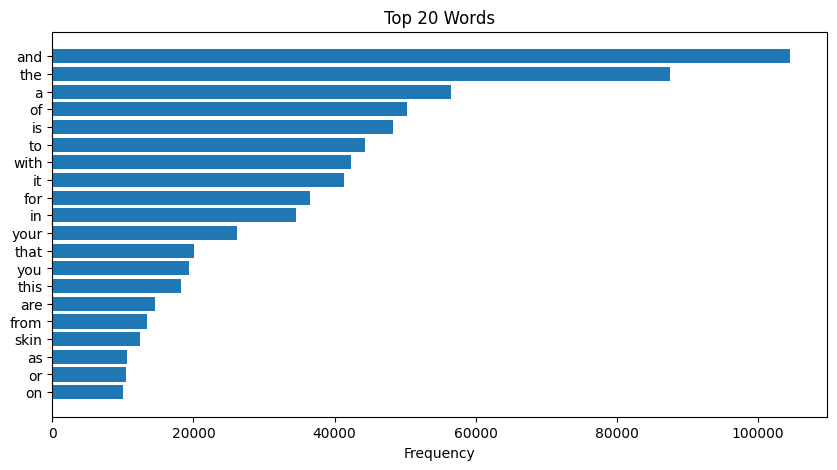

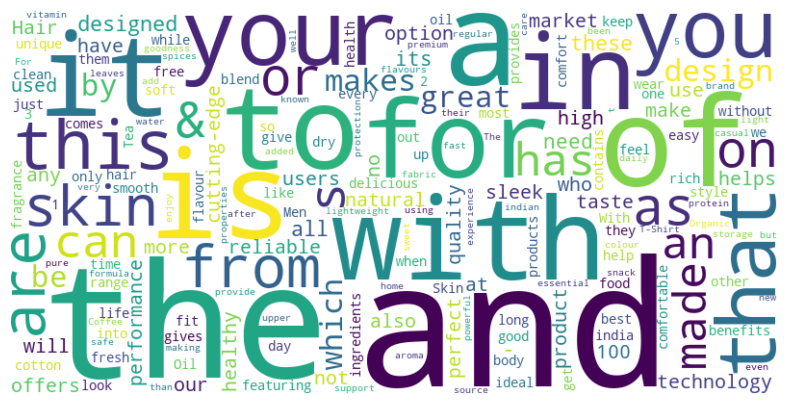

In [32]:
### Visualization ###


all_words = " ".join(clean_Final_data["clean_description"]).split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)

# Bar chart most frequent 20 words
words, counts = zip(*common_words)
plt.figure(figsize=(10,5))
plt.barh(words[::-1], counts[::-1])
plt.xlabel("Frequency")
plt.title("Top 20 Words")
plt.show()

# WordCloud
wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


